## Introduction

Support Vector Machine (SVM) is a type of machine learning algorithm widely used in classification and regression analysis. In this project, SVM will be used to predict the type of seed as either cercvelik or Urgup Sivrisi using the given dataset.

### Abstract

The objective of this project is to build an accurate model for predicting the type of seed by utilizing Support Vector Machine (SVM) algorithm. Consisting of 11 features and 1 target variable, the dataset provides extensive information about different attributes of each type of seed. Initially, the dataset has been pre-processed which included cleaning, data normalization and splitting into training and testing sets. SVM algorithm was implemented with Repeated Stratified K-fold Cross-validation to ensure better generalization and minimize overfitting. Grid search method was applied to tune hyperparameters of SVM that resulted in higher accuracy of the algorithm. As a result of this study, the SVM model has achieved an accuracy maximum of 90% in predicting the type of seed which demonstrates the effectiveness of SVM in classification tasks.

## 1. Data Preprocessing

Imports

In [35]:
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

colors={'Çerçevelik': '#4a4aff', 'Ürgüp Sivrisi': '#ff5151'}

Functions

In [3]:
def plot_features(df, plot_type, **kwargs):
    colors = kwargs.get('colors', {'Çerçevelik': 'blue', 'Ürgüp Sivrisi': 'red'})
    size = kwargs.get('size', 4)
    jitter = kwargs.get('jitter', 0.5)
    kde = kwargs.get("kde", True)

    if plot_type == 'histogram':
        fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20,10))

        for i, col in enumerate(df.columns[df.columns != 'Class']):
            row_idx = i // 4
            col_idx = i % 4

            sns.histplot(data=df, x=col, hue='Class', ax=axs[row_idx, col_idx], alpha=0.7, bins=50, palette=colors,kde=kde, multiple='dodge')

            axs[row_idx, col_idx].legend(labels=['Çerçevelik', 'Ürgüp Sivrisi'])
            axs[row_idx, col_idx].set_title(col)
            axs[row_idx, col_idx].set_xlabel('Value')
            axs[row_idx, col_idx].set_ylabel('Frequency')
        
        fig.tight_layout()
        plt.show()

    elif plot_type == 'boxplot':
        fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20,12))

        for i, col in enumerate(df.columns[df.columns != 'Class']):
            row_idx = i // 4
            col_idx = i % 4

            sns.boxplot(x='Class', y=col, data=df, ax=axs[row_idx, col_idx], palette=colors)

            axs[row_idx, col_idx].set_title(col)
        
        fig.tight_layout()
        plt.show()
        
    elif plot_type == 'stripplot':
        fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20,15))

        for i, col in enumerate(df.columns[df.columns != 'Class']):
            row_idx = i // 4
            col_idx = i % 4

            sns.stripplot(x='Class', y=col, data=df, ax=axs[row_idx, col_idx],hue='Class', palette=colors,size=size,jitter=jitter)

            axs[row_idx, col_idx].set_title(col)

        fig.tight_layout()
        plt.show()

    else:
        print(f"Invalid plot type '{plot_type}', please choose 'histogram', 'stripplot', or 'boxplot'.")



Data Loading

In [4]:
df = pd.read_excel("Pumpkin_Seeds_Dataset.xlsx")
df.head()

Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Convex_Area  \
0  56276    888.242           326.1485           220.2388        56831   
1  76631   1068.146           417.1932           234.2289        77280   
2  71623   1082.987           435.8328           211.0457        72663   
3  66458    992.051           381.5638           222.5322        67118   
4  66107    998.146           383.8883           220.4545        67117   

   Equiv_Diameter  Eccentricity  Solidity  Extent  Roundness  Aspect_Ration  \
0        267.6805        0.7376    0.9902  0.7453     0.8963         1.4809   
1        312.3614        0.8275    0.9916  0.7151     0.8440         1.7811   
2        301.9822        0.8749    0.9857  0.7400     0.7674         2.0651   
3        290.8899        0.8123    0.9902  0.7396     0.8486         1.7146   
4        290.1207        0.8187    0.9850  0.6752     0.8338         1.7413   

   Compactness       Class  
0       0.8207  Çerçevelik  
1       0.7487  Çerçevelik  
2       0.6929  Çerçevelik  
3       0.7624  Çerçevelik  
4       0.7557  Çerçevelik

Basic but important information about the data

In [5]:
shape =df.shape
columns = df.columns
print("Shape of the dataset: {}".format(df.shape))

Shape of the dataset: (2500, 13)


Understanding difficult-word coulmns
1. [Major and Minor axis](https://www.idseed.org/ckfinder/userfiles/images/LENGTH%20&%20WIDTH.png): In simpler terms, if you were to draw an ellipse aroun the seed, the 'Major_Axis_Length' would be the length of the longer axis of the ellipse. Vice versa to the 'Minor_Axis_Length' would be the length of the shorter axis of the ellipse.
2. Equivalent diameter: imagining the seed is stretched to be a circle then mesuring it's diameter.
3. Eccentricity: how much the seed has a thin line, if the seed is perfectly circular then the eccentricity value will be zero, if it is a long thin line, the value will be close to one.
4. Extent: how much the seed closely resembles a pumpkin seed. A higher value indicates that the seed is more similar in shape to a pumpkin while lower values indicate that the seed is less similar shape.
5. Compactness: amount of space needed to enclose the seed.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               2500 non-null   int64  
 1   Perimeter          2500 non-null   float64
 2   Major_Axis_Length  2500 non-null   float64
 3   Minor_Axis_Length  2500 non-null   float64
 4   Convex_Area        2500 non-null   int64  
 5   Equiv_Diameter     2500 non-null   float64
 6   Eccentricity       2500 non-null   float64
 7   Solidity           2500 non-null   float64
 8   Extent             2500 non-null   float64
 9   Roundness          2500 non-null   float64
 10  Aspect_Ration      2500 non-null   float64
 11  Compactness        2500 non-null   float64
 12  Class              2500 non-null   object 
dtypes: float64(10), int64(2), object(1)
memory usage: 254.0+ KB


No nulls in our data, datatypes are suitable.

In [7]:
df.duplicated().sum()

0

No duplicates in our dataset

### Visualizations

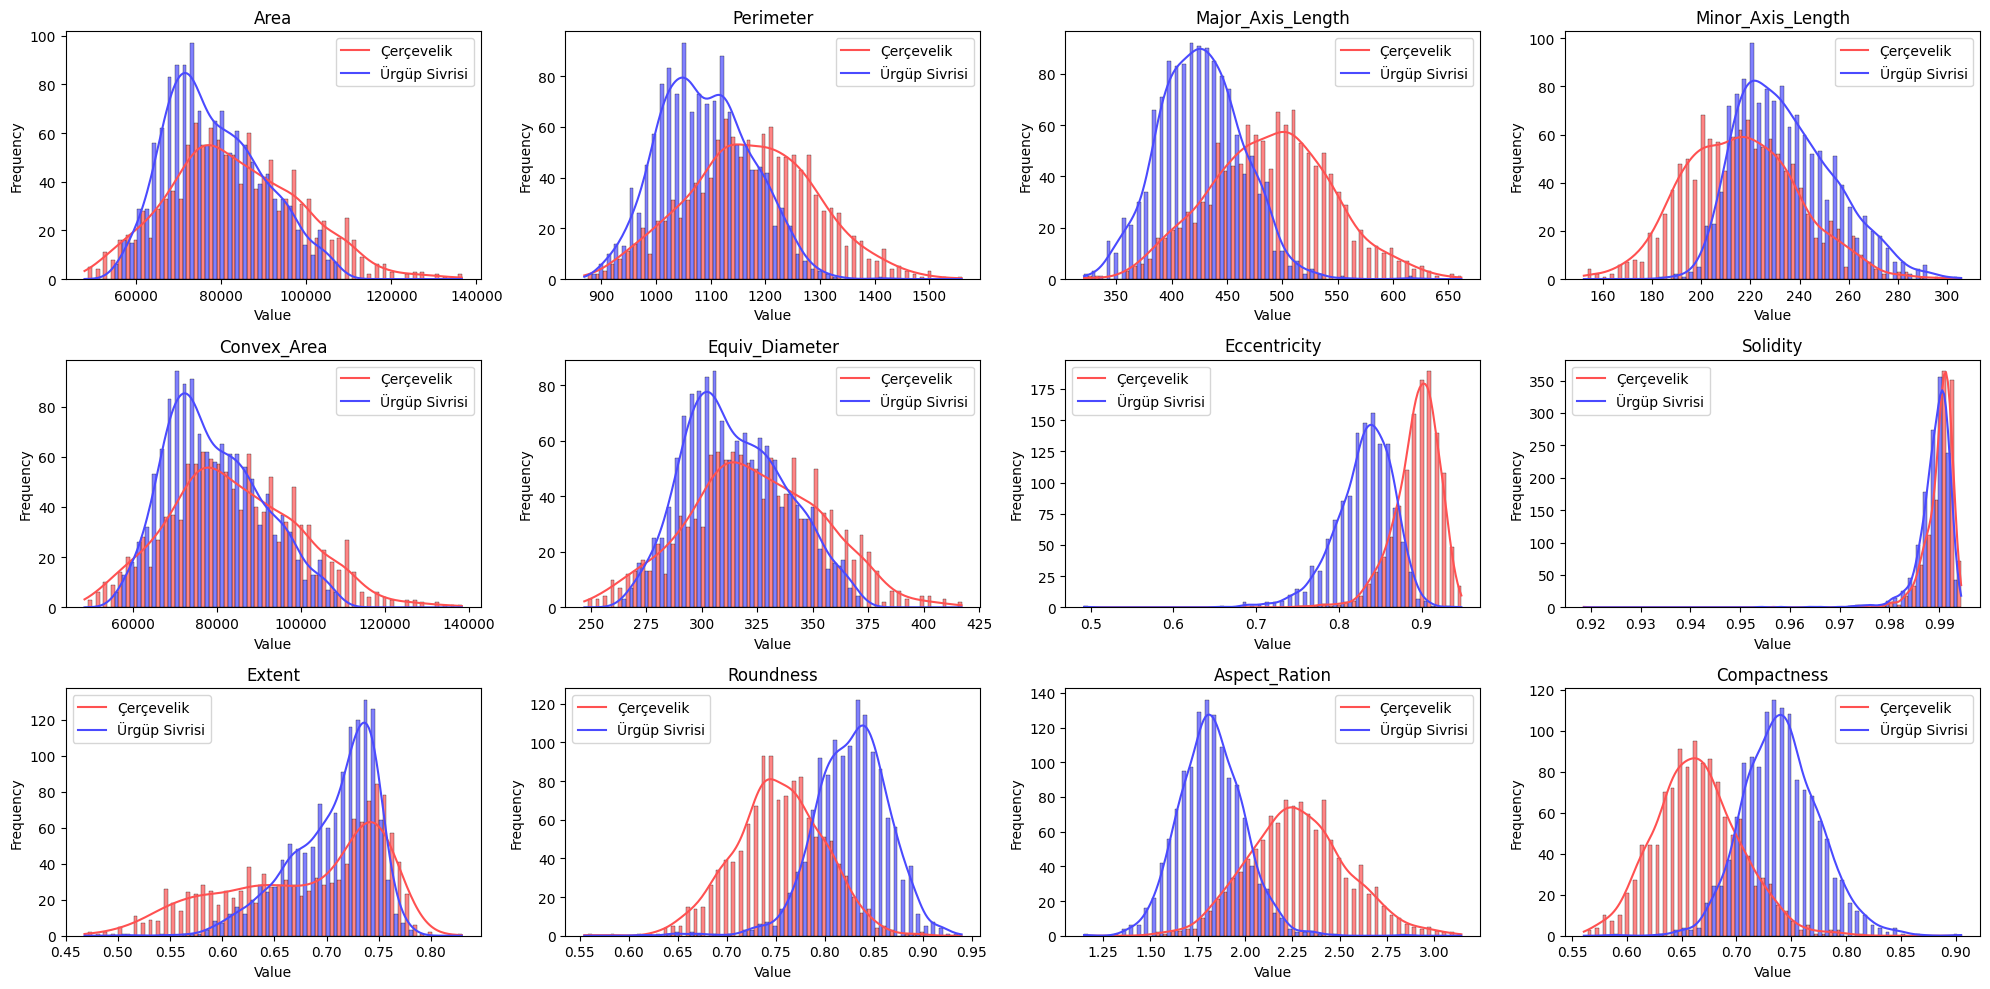

In [8]:
plot_features(df, plot_type='histogram', colors=colors)

<a id="conclusions"></a>
**We can conclude insights here**

The features Area, Perimeter, Major Axis Length, Convex Area, Equiv Diameter, Eccentricity, and Aspect Ratio all have higher values for the Ürgüp Sivrisi seeds, while these features are not as high for the Çerçevelik-type seeds.
Minor axis length is higher in Çerçevelik-type seeds compared to Ürgüp Sivrisi.
Roundness and Compactness are also higher in the Çerçevelik-type seeds.

Therefore, by examining these features we can distinguish between the two types of pumpkin seeds with a good degree of accuracy.



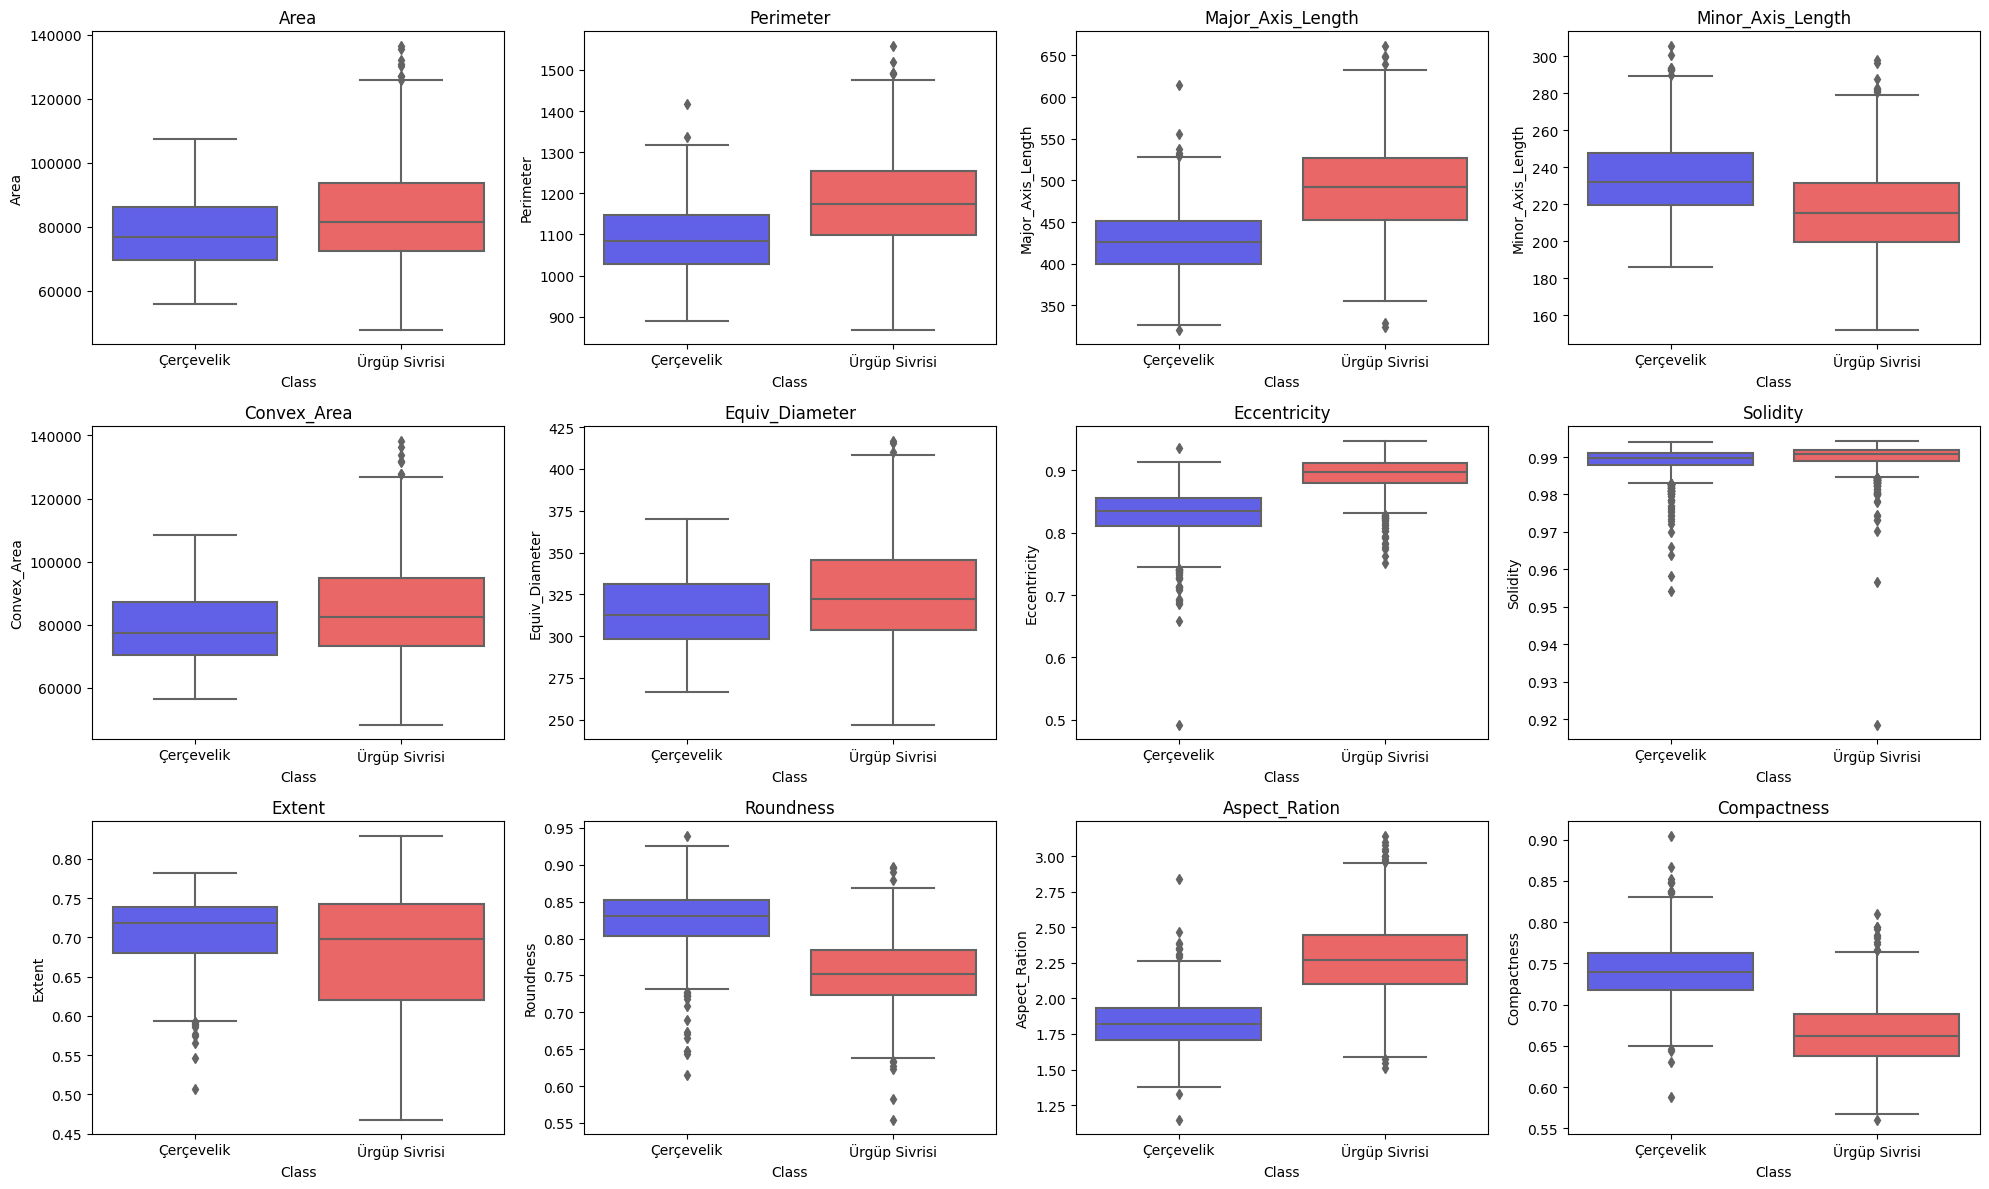

In [9]:
plot_features(df, plot_type='boxplot', colors=colors)

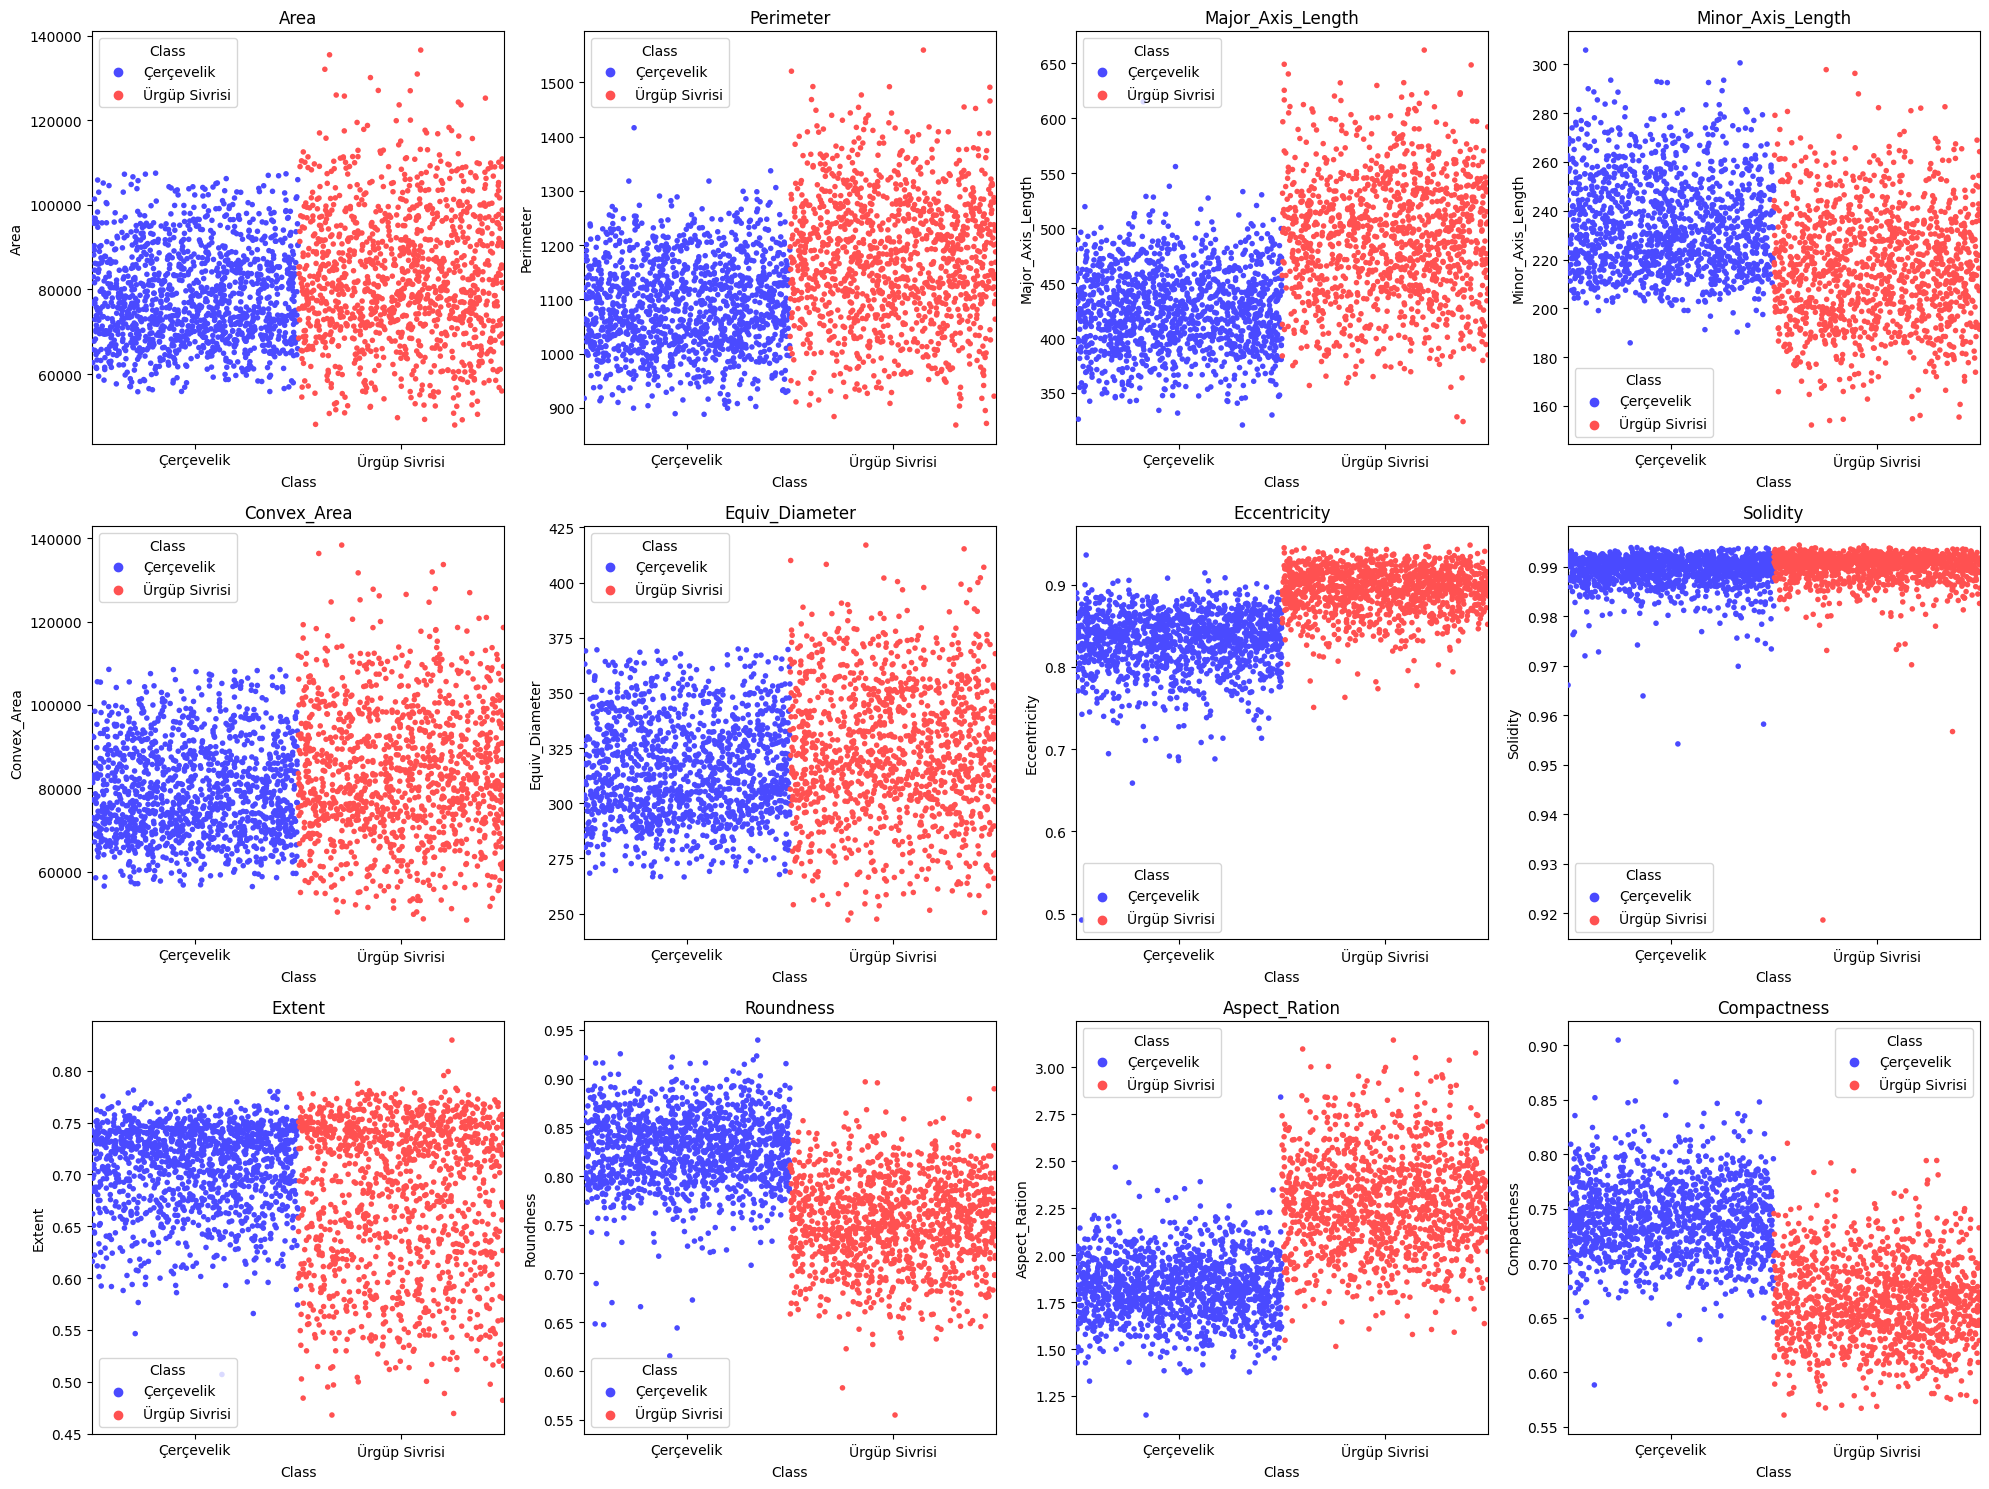

In [10]:
plot_features(df, plot_type='stripplot', size=4, jitter=0.5, colors=colors)

In [17]:
Numeric_data = df.iloc[:,:-1]
corrs = Numeric_data.corr()

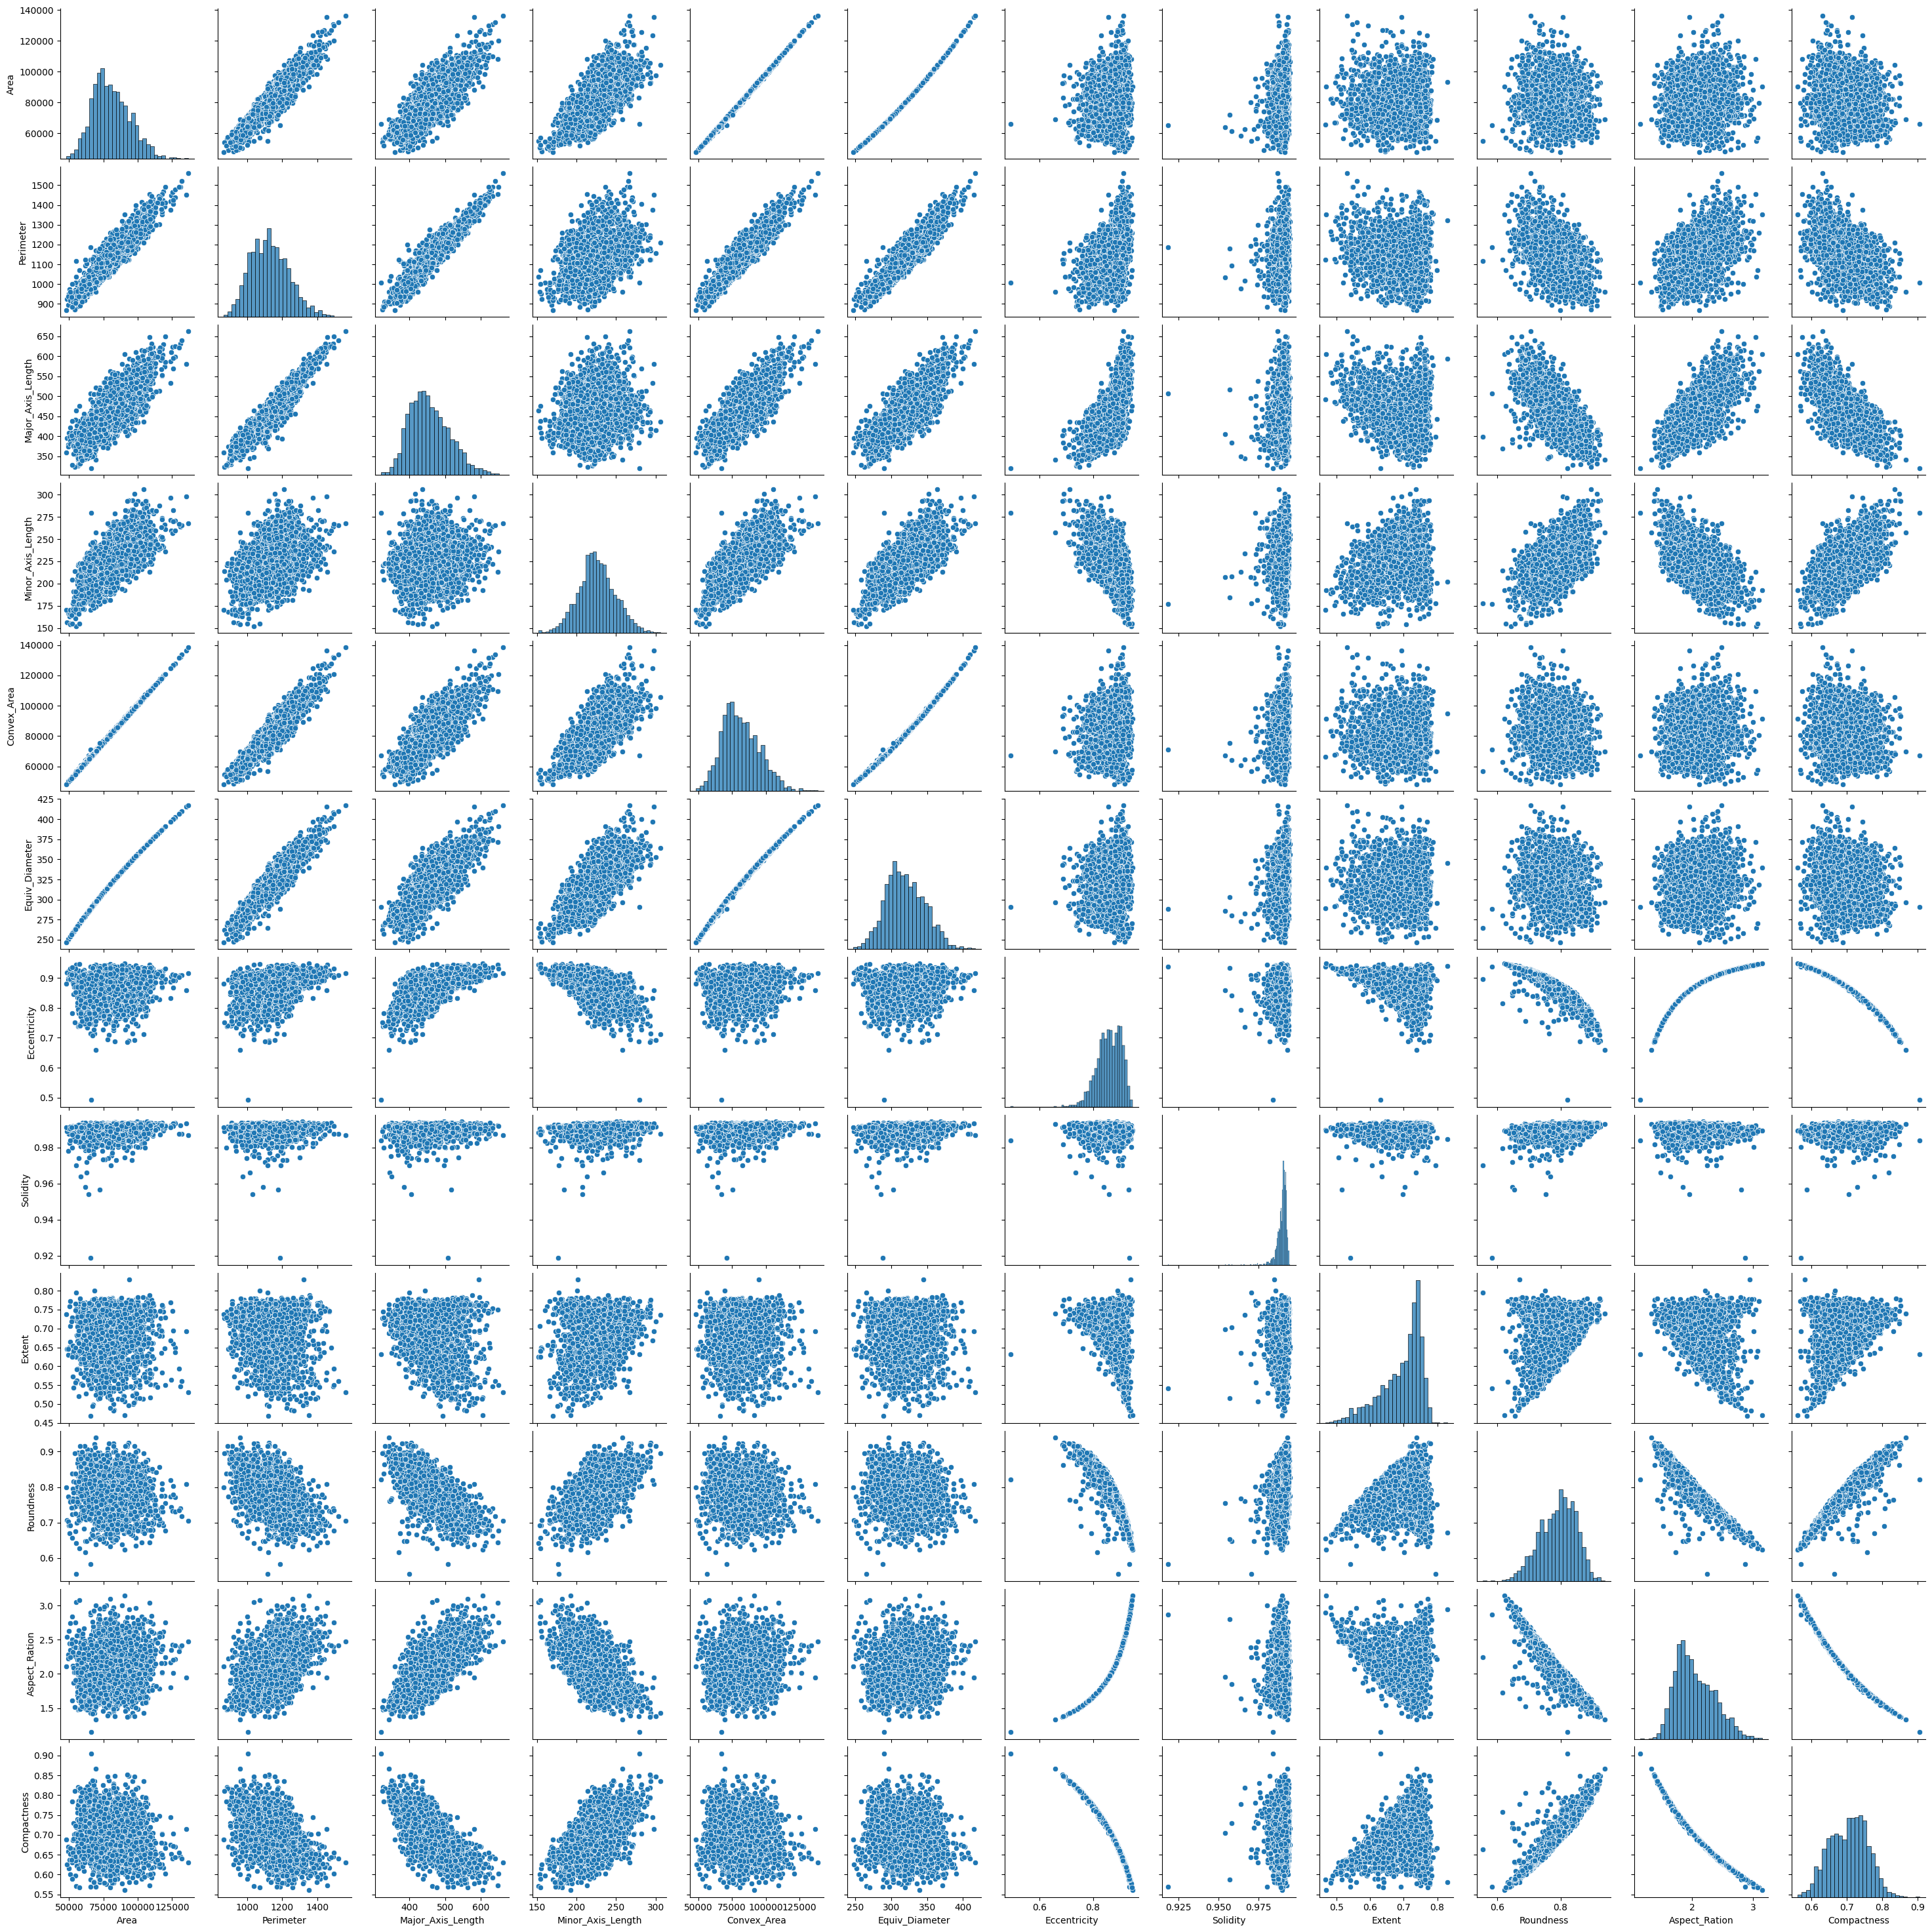

In [38]:
sns.pairplot(Numeric_data)

We can emphasize our [conclusions](#conclusions) from these plots above
* we also conclude that Ürgüp Sivrisi seeds are more ranged than Çerçevelik seeds in most cases like: Area, Perimeter, Axis length, etc. 

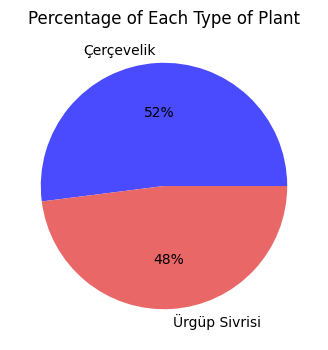

In [ ]:

class_counts = df['Class'].value_counts()
plt.figure(figsize=(4,4))
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.0f%%',colors=['#4a4aff','#e96767'])
plt.title('Percentage of Each Type of Plant')
plt.show()


<AxesSubplot: >

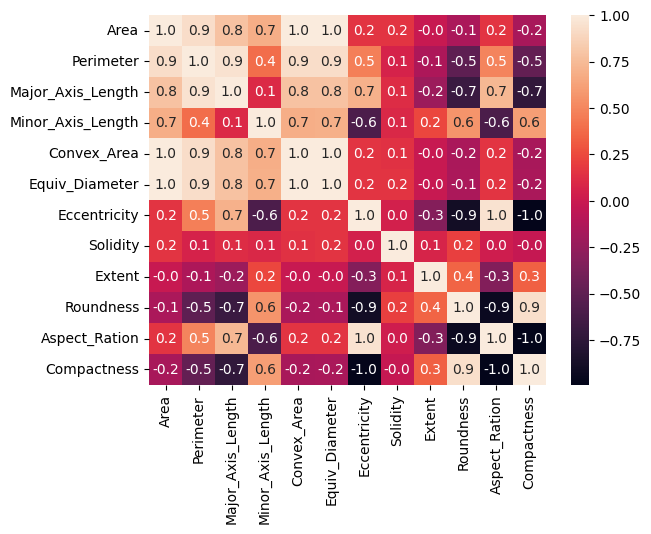

In [21]:
sns.heatmap(corrs,annot=True, fmt=".1f")

Columns that have strong correlations:
(Eccentricity-Compacness), (Aspect Ratio-Compacness), (Roundeness-Eccentricity), (Roundness-Aspect Ratio).

In [ ]:
Urgup_df = df[df['Class']=="Ürgüp Sivrisi"]
cercevelik_df = df[df['Class']=="Çerçevelik"]


In [ ]:
# Numeric comparison between Ürgüp Sivrisi and Çerçevelik seeds.

urgup_stats = Urgup_df.describe()
cercevelik_stats = cercevelik_df.describe()

combined_stats = pd.concat([urgup_stats, cercevelik_stats], keys=['Ürgüp Sivrisi', 'Çerçevelik'])
combined_stats


Area    Perimeter  Major_Axis_Length  \
Ürgüp Sivrisi count    1200.000000  1200.000000        1200.000000   
              mean    83079.542500  1174.431919         489.458501   
              std     15519.323847   116.793253          54.904345   
              min     47939.000000   868.485000         324.011300   
              25%     72482.500000  1097.747250         451.870625   
              50%     81657.000000  1173.716500         491.518300   
              75%     93815.750000  1254.794000         526.521050   
              max    136574.000000  1559.450000         661.911300   
Çerçevelik    count    1300.000000  1300.000000        1300.000000   
              mean    78423.154615  1089.522488         426.272615   
              std     11246.499728    83.128407          37.196923   
              min     55811.000000   888.242000         320.844600   
              25%     69777.750000  1027.614000         399.972475   
              50%     76718.500000  1083.189500         425.426550   
              75%     86277.750000  1146.549250         451.430375   
              max    107476.000000  1416.303000         614.895900   

                     Minor_Axis_Length    Convex_Area  Equiv_Diameter  \
Ürgüp Sivrisi count        1200.000000    1200.000000     1200.000000   
              mean          216.064413   83914.813333      323.820202   
              std            23.173521   15624.711959       30.354631   
              min           152.171800   48366.000000      247.058400   
              25%           199.328900   73267.750000      303.788750   
              50%           215.294650   82446.500000      322.442100   
              75%           231.376300   94804.500000      345.615300   
              max           297.795200  138384.000000      417.002900   
Çerçevelik    count        1300.000000    1300.000000     1300.000000   
              mean          234.776929   79286.488462      315.193332   
              std            19.500795   11350.508104       22.472502   
              min           185.844000   56394.000000      266.572300   
              25%           219.773150   70522.000000      298.066750   
              50%           232.093600   77525.500000      312.539650   
              75%           247.596175   87213.500000      331.439650   
              max           305.818000  108536.000000      369.922600   

                     Eccentricity     Solidity       Extent    Roundness  \
Ürgüp Sivrisi count   1200.000000  1200.000000  1200.000000  1200.000000   
              mean       0.893749     0.989938     0.678240     0.752570   
              std        0.027247     0.003550     0.074216     0.045543   
              min        0.750700     0.918600     0.468000     0.554600   
              25%        0.879375     0.988900     0.620800     0.723875   
              50%        0.897650     0.990700     0.698000     0.752200   
              75%        0.912450     0.991800     0.742400     0.783800   
              max        0.948100     0.994400     0.829600     0.896700   
Çerçevelik    count   1300.000000  1300.000000  1300.000000  1300.000000   
              mean       0.830538     0.989080     0.707018     0.827499   
              std        0.036333     0.003391     0.040698     0.037485   
              min        0.492100     0.954200     0.507100     0.615300   
              25%        0.810775     0.987900     0.680550     0.803400   
              50%        0.835400     0.989800     0.718150     0.829900   
              75%        0.855625     0.991200     0.739200     0.852400   
              max        0.936000     0.993900     0.781400     0.939600   

                     Aspect_Ration  Compactness  
Ürgüp Sivrisi count    1200.000000  1200.000000  
              mean        2.279054     0.663991  
              std         0.262546     0.038586  
              min         1.513800     0.560800  
              25%         2.099950     0.637900  
    

In [ ]:
df.groupby('Class').skew()

Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  \
Class                                                                      
Çerçevelik     0.418354   0.213018           0.190791           0.574994   
Ürgüp Sivrisi  0.310580   0.056191           0.058515           0.229002   

               Convex_Area  Equiv_Diameter  Eccentricity  Solidity    Extent  \
Class                                                                          
Çerçevelik        0.419941        0.280698     -1.361841 -3.176233 -0.922410   
Ürgüp Sivrisi     0.310916        0.069773     -1.053895 -8.352404 -0.594304   

               Roundness  Aspect_Ration  Compactness  
Class                                                 
Çerçevelik     -0.648196       0.299341     0.241559  
Ürgüp Sivrisi  -0.125832       0.201082     0.285848

In [ ]:
# how much histograms are thin
df.groupby('Class').apply(pd.DataFrame.kurt)

C:\Users\Jonat\AppData\Local\Temp\ipykernel_592\4275971221.py:2: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.groupby('Class').apply(pd.DataFrame.kurt)
C:\Users\Jonat\AppData\Local\Temp\ipykernel_592\4275971221.py:2: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.groupby('Class').apply(pd.DataFrame.kurt)


Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  \
Class                                                                      
Çerçevelik    -0.521082  -0.366790           0.229110          -0.093053   
Ürgüp Sivrisi -0.130030  -0.240492          -0.177666          -0.028920   

               Convex_Area  Equiv_Diameter  Eccentricity    Solidity   Extent  \
Class                                                                           
Çerçevelik       -0.527158       -0.617802      6.650227   20.127332  0.52421   
Ürgüp Sivrisi    -0.127891       -0.280830      2.086161  143.726920 -0.77628   

               Roundness  Aspect_Ration  Compactness  
Class                                                 
Çerçevelik      2.256317       1.220498     0.738563  
Ürgüp Sivrisi   0.180593       0.049698     0.215050

By knowing the the skewness and the kurtosis of each column we get the following insights:

* Ürgüp Sivrisi seeds are more ranged than Çerçevelik seeds so Ürgüp Sivrisi seeds' shape is more randomized and we can find different sizes of it.
* Çerçevelik is more skewed to the right than Ürgüp Sivrisi seeds in most of the data so we configure that it can have bigger values in most features.

# SVM

In [25]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

array(['Çerçevelik', 'Çerçevelik', 'Çerçevelik', ..., 'Ürgüp Sivrisi',
       'Ürgüp Sivrisi', 'Ürgüp Sivrisi'], dtype=object)

1. Splitting the data into features and target then splitting into RepeatedStratifiedKFold because Percentage of plant types differs slightly.
2. Hyperparameter tuning to get best parameters for SVM using GridSearchCV
3. Printing the results with classifications report 

In [37]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

# Splitting the data into features and target variable
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Define pipeline steps
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(probability=True))]

pipeline = Pipeline(steps)

# Define parameter grid for GridSearch
param_grid = {'SVM__C': [0.01, 0.1, 1],
              'SVM__gamma': [0.1, 1, 10, 100]}

# Create stratified K-fold object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Create GridSearch object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='accuracy', cv=cv, verbose=1)

best_accs = []

# Evaluate pipeline performance using GridSearchCV
for train_idx, test_idx in cv.split(X, y):
    # Splitting the data using stratified k-fold cross-validation
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    # Fit the pipeline on training data
    grid_search.fit(X_train, y_train)

    # Append best accuracy score to a list
    best_accs.append(grid_search.best_score_)

    # Print classification report for each fold
    print(f"Classification Report:\n{classification_report(y_test, grid_search.predict(X_test))}\n")

    # Print best parameters
    print(f"Best parameters: {grid_search.best_params_}\n")

# Mean accuracy of all folds
print(f"Mean accuracy: {np.mean(best_accs)}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Classification Report:
               precision    recall  f1-score   support

   Çerçevelik       0.89      0.93      0.91       260
Ürgüp Sivrisi       0.92      0.87      0.90       240

     accuracy                           0.90       500
    macro avg       0.90      0.90      0.90       500
 weighted avg       0.90      0.90      0.90       500


Best parameters: {'SVM__C': 1, 'SVM__gamma': 0.1}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Classification Report:
               precision    recall  f1-score   support

   Çerçevelik       0.87      0.91      0.89       260
Ürgüp Sivrisi       0.90      0.85      0.88       240

     accuracy                           0.88       500
    macro avg       0.89      0.88      0.88       500
 weighted avg       0.88      0.88      0.88       500


Best parameters: {'SVM__C': 1, 'SVM__gamma': 0.1}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
C

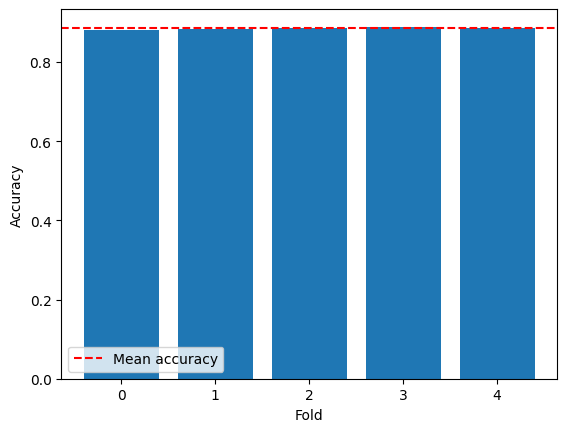

In [39]:
import matplotlib.pyplot as plt

# Plot accuracy scores for each fold
fig, ax = plt.subplots()
ax.bar(range(len(best_accs)), best_accs)
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')

# Add mean accuracy line
ax.axhline(y=np.mean(best_accs), color='r', linestyle='--', label='Mean accuracy')

# Show legend and plot
ax.legend()
plt.show()


## Conclusion:

In conclusion, Support Vector Machine (SVM) is a powerful tool for classification tasks based on its ability to maximize the margin between classes. The application of SVM on this study resulted in an accurate prediction model for identifying the type of seed as either cercvelik or Urgup Sivrisi. With the increasing amount of data and complex problems, SVM has become an essential tool for various applications in science, engineering and machine learning.